# Web Scrape for Data

In [1]:
#Helpers libraries
import pandas as pd
# from urllib.request import urlopen  
# import os.path as osp
# import os
# import logging
# import zipfile
# from glob import glob
# logging.getLogger().setLevel('INFO')
from datetime import datetime,timedelta
# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
base_url = 'http://tennis-data.co.uk'
data_dir = 'desktop/coding/sports_betting/tennis'

atp_urls = [base_url + '/%i/%i.xlsx' %(i,i) for i in range(2000,2021)]
        
import requests

file_names = [data_dir + '/ATP/%i.xlsx' %i for i in range(2000,2021)]

for url, file in zip(atp_urls,file_names):
    r = requests.get(url, allow_redirects=True)
    open(file, 'wb').write(r.content)

In [ ]:
df_atp = pd.concat([pd.read_excel(f) for f in file_names], ignore_index=True)

In [ ]:
# #Helpers fucntions

# def download_file(url_str, path):
#     url = urlopen(url_str)
#     output = open(path, 'wb')       
#     output.write(url.read())
#     output.close()  
    
# def extract_file(archive_path, target_dir):
#     zip_file = zipfile.ZipFile(archive_path, 'r')
#     zip_file.extractall(target_dir)
#     zip_file.close()

In [ ]:
# BASE_URL = 'http://tennis-data.co.uk'
# DATA_DIR = "desktop/coding/sports_betting/tennis" #Change it depending on where you want to store the files
# ATP_DIR = './{}/ATP'.format(DATA_DIR)
# WTA_DIR = './{}/WTA'.format(DATA_DIR)

# ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2021)]
# WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2021)]

# os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
# os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

# for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
#     for dl_path in files:
#         logging.info("downloading & extracting file %s", dl_path)
#         archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
#         download_file(dl_path, archive_path)
#         extract_file(archive_path, directory)
    
# ATP_FILES = sorted(glob("%s/*.*" % ATP_DIR))
# WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

# df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
# df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

# logging.info("%i matches ATP in df_atp", df_atp.shape[0])
# logging.info("%i matches WTA in df_wta", df_wta.shape[0])

In [ ]:
df_atp.to_csv("Notebooks_other/df_atp.csv")

# EDA

In [2]:
# Libraries loading
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew #statistics for normality and skewness
import numpy as np
ip = get_ipython()
ibe = ip.configurables[-1]
ibe.figure_formats = { 'pdf', 'png'}

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df_atp = pd.read_csv('Notebooks_other/df_atp.csv',index_col=0)
df_atp["Date"] =df_atp.Date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [5]:
print('Number of Matches: {}'.format(len(df_atp)))

Number of Matches: 56175


In [6]:
print(df_atp.columns)

Index(['ATP', 'AvgL', 'AvgW', 'B&WL', 'B&WW', 'B365L', 'B365W', 'Best of',
       'CBL', 'CBW', 'Comment', 'Court', 'Date', 'EXL', 'EXW', 'GBL', 'GBW',
       'IWL', 'IWW', 'L1', 'L2', 'L3', 'L4', 'L5', 'LBL', 'LBW', 'LPts',
       'LRank', 'Location', 'Loser', 'Lsets', 'MaxL', 'MaxW', 'PSL', 'PSW',
       'Round', 'SBL', 'SBW', 'SJL', 'SJW', 'Series', 'Surface', 'Tournament',
       'UBL', 'UBW', 'W1', 'W2', 'W3', 'W4', 'W5', 'WPts', 'WRank', 'Winner',
       'Wsets'],
      dtype='object')


In [7]:
df_atp['Winner'].value_counts()[0:5]

Federer R.     1177
Nadal R.        966
Djokovic N.     891
Ferrer D.       699
Murray A.       637
Name: Winner, dtype: int64

In [8]:
df_atp.shape

(56175, 54)

In [9]:
df_atp.drop('ATP', axis=1, inplace=True)

In [10]:
df_atp.shape

(56175, 53)

In [11]:
df_atp[['Wsets','Lsets']] = df_atp[['Wsets','Lsets']].fillna(0)

In [12]:
# Function to make sure data is cast as a number, not an object
def win_loss_clean(x):
    try:
        if float(x):
            return float(x)
    except:
        return 0

In [13]:
column_list = ['W1','W2','W3','W4','W5','L1','L2','L3','L4','L5']
for name in column_list:
    df_atp[name] = df_atp[name].apply(lambda x: win_loss_clean(x)).fillna(0)


In [14]:
df_atp = df_atp.sort_values(by = 'Date')

### Dictionary and array to calculate overall and surface-specific match win %'s for both players in a given match

In [15]:
win_loss = np.zeros((len(df_atp),4)) #win % winner, win % loser, win % winner on surface, win % loser on surface

In [16]:
player_index_and_court = {}
# Dictionary with player name as key, values are a list
# [unique player index, matches won, matches played, won hard , played hard, won clay, played clay, 
# won grass, played grass, won carpet, played carpet]

i = 0

for player in df_atp['Winner'].unique():
    if player not in player_index_and_court.keys():
        player_index_and_court[player] = [i,0,0,0,0,0,0,0,0,0,0]
        i +=1
for player in df_atp['Loser'].unique():
    if player not in player_index_and_court.keys():
        player_index_and_court[player] = [i,0,0,0,0,0,0,0,0,0,0]
        i +=1
print('Number of unique players: %i' %i)

Number of unique players: 1553


In [17]:
for c, row in enumerate(df_atp[['Winner','Loser','Surface']].values):
    winner = player_index_and_court[row[0]] # value list of dict for the winner
    loser = player_index_and_court[row[1]]  # value list of dict for the loser
    surface = row[2]
   

    if winner[2] < 5: #If less than 5 matches played give a win % of 50%
        win_loss[c,0] = 0.25   
    else:
        win_loss[c,0] = winner[1] / winner[2]
        
    if surface == 'Hard':
        if winner[4] < 5:
            win_loss[c,2] = 0.25
        else:
            win_loss[c,2] = winner[3] / winner[4]
        player_index_and_court[row[0]][3]+=1
        player_index_and_court[row[0]][4]+=1
            
    if surface == 'Clay':
        if winner[6] < 5:
            win_loss[c,2] = 0.25
        else:
            win_loss[c,2] = winner[5] / winner[6]
        player_index_and_court[row[0]][5]+=1
        player_index_and_court[row[0]][6]+=1
            
    if surface == 'Grass':
        if winner[8] < 5:
            win_loss[c,2] = 0.25
        else:
            win_loss[c,2] = winner[7] / winner[8]
        player_index_and_court[row[0]][7]+=1
        player_index_and_court[row[0]][8]+=1
             
    if surface == 'Carpet':
        if winner[10] < 5:
            win_loss[c,2] = 0.25
        else:
            win_loss[c,2] = winner[9] / winner[10]
        player_index_and_court[row[0]][9]+=1
        player_index_and_court[row[0]][10]+=1
    
    if loser[2] < 5: #If less than 5 matches played give win % of 10%
        win_loss[c,1] = 0.25
    else:
        win_loss[c,1] = loser[1] / loser[2]
        
    if surface == 'Hard':
        if loser[4] < 5:
            win_loss[c,3] = 0.25
        else:
            win_loss[c,3] = loser[3] / loser[4]
        player_index_and_court[row[1]][4]+=1
            
    if surface == 'Clay':
        if loser[6] < 5:
            win_loss[c,3] = 0.25
        else:
            win_loss[c,3] = loser[5] / loser[6]
        player_index_and_court[row[1]][6]+=1
            
    if surface == 'Grass':
        if loser[8] < 5:
            win_loss[c,3] = 0.25
        else:
            win_loss[c,3] = loser[7] / loser[8]
        player_index_and_court[row[1]][8]+=1
             
    if surface == 'Carpet':
        if loser[10] < 5:
            win_loss[c,3] = 0.25
        else:
            win_loss[c,3] = loser[9] / loser[10]
        player_index_and_court[row[1]][10]+=1

    player_index_and_court[row[0]][1]+=1
    player_index_and_court[row[0]][2]+=1
    
    player_index_and_court[row[1]][2]+=1

### Dictionary and array to calculate overall and surface-specific set and game win %'s for both players in a given match

In [18]:
sets_games = np.zeros((len(df_atp),8)) 
# win % sets winner, win % sets loser, win % sets winner on surface, win % sets loser on surface
# win % games winner, win % games loser, win % games winner on surface, win % games loser on surface

In [19]:
player_index_sets_games = {}
# Dictionary with player name as key, values are a list
# 0: unique player index, 1: sets won, 2: sets played, 3: sets won hard , 4: sets played hard, 5: sets won clay, 6: sets played clay, 
# 7: sets won grass, 8: sets played grass, 9: sets won carpet, 10: sets played carpet
# 11: games won, 12: games played, 13: games won hard , 14: games played hard, 15: games won clay, 16: games played clay, 
# 17: games won grass, 18: games played grass, 19: games won carpet, 20: games played carpet

i = 0

for player in df_atp['Winner'].unique():
    if player not in player_index_sets_games.keys():
        player_index_sets_games[player] = [i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        i +=1
for player in df_atp['Loser'].unique():
    if player not in player_index_sets_games.keys():
        player_index_sets_games[player] = [i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        i +=1
print('Number of unique players: %i' %i)

Number of unique players: 1553


In [20]:
for c, row in enumerate(df_atp[['Winner','Loser','Surface','Wsets','Lsets',
                               'W1','W2','W3','W4','W5',
                               'L1','L2','L3','L4','L5']].values):
    
    winner = player_index_sets_games[row[0]] # value list of dict for the winner
    loser = player_index_sets_games[row[1]]  # value list of dict for the loser
    surface = row[2]
    winner_sets_won = row[3]
    loser_sets_won = row[4]
    total_sets = row[3] + row[4]
    winner_games_won = row[5:10].sum()
    loser_games_won = row[10:15].sum()
    total_games = winner_games_won + loser_games_won
   

    ######### Sets played and won in total and on specific surface by Winner and by Loser ##############
    
    if winner[2] < 5: #If less than 5 sets played give a win % of 25%
        sets_games[c,0] = 0.25   
    else:
        sets_games[c,0] = winner[1] / winner[2]
        
    if surface == 'Hard':
        if winner[4] < 5:
            sets_games[c,2] = 0.25
        else:
            sets_games[c,2] = winner[3] / winner[4]
        player_index_sets_games[row[0]][3]+=winner_sets_won
        player_index_sets_games[row[0]][4]+=total_sets
            
    if surface == 'Clay':
        if winner[6] < 5:
            sets_games[c,2] = 0.25
        else:
            sets_games[c,2] = winner[5] / winner[6]
        player_index_sets_games[row[0]][5]+=winner_sets_won
        player_index_sets_games[row[0]][6]+=total_sets
            
    if surface == 'Grass':
        if winner[8] < 5:
            sets_games[c,2] = 0.25
        else:
            sets_games[c,2] = winner[7] / winner[8]
        player_index_sets_games[row[0]][7]+=winner_sets_won
        player_index_sets_games[row[0]][8]+=total_sets
             
    if surface == 'Carpet':
        if winner[10] < 5:
            sets_games[c,2] = 0.25
        else:
            sets_games[c,2] = winner[9] / winner[10]
        player_index_sets_games[row[0]][9]+=winner_sets_won
        player_index_sets_games[row[0]][10]+=total_sets
    
    if loser[2] < 5: #If less than 5 sets played give win % of 25%
        sets_games[c,1] = 0.25
    else:
        sets_games[c,1] = loser[1] / loser[2]
        
    if surface == 'Hard':
        if loser[4] < 5:
            sets_games[c,3] = 0.25
        else:
            sets_games[c,3] = loser[3] / loser[4]
        player_index_sets_games[row[1]][3]+=loser_sets_won
        player_index_sets_games[row[1]][4]+=total_sets
            
    if surface == 'Clay':
        if loser[6] < 5:
            sets_games[c,3] = 0.25
        else:
            sets_games[c,3] = loser[5] / loser[6]
        player_index_sets_games[row[1]][5]+=loser_sets_won
        player_index_sets_games[row[1]][6]+=total_sets
            
    if surface == 'Grass':
        if loser[8] < 5:
            sets_games[c,3] = 0.25
        else:
            sets_games[c,3] = loser[7] / loser[8]
        player_index_sets_games[row[1]][7]+=loser_sets_won
        player_index_sets_games[row[1]][8]+=total_sets
             
    if surface == 'Carpet':
        if loser[10] < 5:
            sets_games[c,3] = 0.25
        else:
            sets_games[c,3] = loser[9] / loser[10]
        player_index_sets_games[row[1]][9]+=loser_sets_won
        player_index_sets_games[row[1]][10]+=total_sets
        
    player_index_sets_games[row[0]][1]+=winner_sets_won #Increment number of sets won by Winner
    player_index_sets_games[row[0]][2]+=total_sets #Increment number of sets played by Winner
    
    player_index_sets_games[row[1]][1]+=loser_sets_won #Increment number of sets won by Loser
    player_index_sets_games[row[1]][2]+=total_sets #Increment number of sets played by Loser
    
    
    
    ######### Games played and won in total and on specific surface by Winner and by Loser ##############
    
    
    
    if winner[12] < 5: #If less than 5 games played give a win % of 25%
        sets_games[c,4] = 0.25   
    else:
        sets_games[c,4] = winner[11] / winner[12]
        
    if surface == 'Hard':
        if winner[14] < 5:
            sets_games[c,6] = 0.25
        else:
            sets_games[c,6] = winner[13] / winner[14]
        player_index_sets_games[row[0]][13]+=winner_games_won
        player_index_sets_games[row[0]][14]+=total_games
            
    if surface == 'Clay':
        if winner[16] < 5:
            sets_games[c,6] = 0.25
        else:
            sets_games[c,6] = winner[15] / winner[16]
        player_index_sets_games[row[0]][15]+=winner_games_won
        player_index_sets_games[row[0]][16]+=total_games
            
    if surface == 'Grass':
        if winner[18] < 5:
            sets_games[c,6] = 0.25
        else:
            sets_games[c,6] = winner[17] / winner[18]
        player_index_sets_games[row[0]][17]+=winner_games_won
        player_index_sets_games[row[0]][18]+=total_games
             
    if surface == 'Carpet':
        if winner[20] < 5:
            sets_games[c,6] = 0.25
        else:
            sets_games[c,6] = winner[19] / winner[20]
        player_index_sets_games[row[0]][19]+=winner_games_won
        player_index_sets_games[row[0]][20]+=total_games
    
    if loser[12] < 5: #If less than 5 sets played give win % of 50%
        sets_games[c,5] = 0.25
    else:
        sets_games[c,5] = loser[11] / loser[12]
        
    if surface == 'Hard':
        if loser[14] < 5:
            sets_games[c,7] = 0.25
        else:
            sets_games[c,7] = loser[13] / loser[14]
        player_index_sets_games[row[1]][13]+=loser_games_won
        player_index_sets_games[row[1]][14]+=total_games
            
    if surface == 'Clay':
        if loser[16] < 5:
            sets_games[c,7] = 0.25
        else:
            sets_games[c,7] = loser[15] / loser[16]
        player_index_sets_games[row[1]][15]+=loser_games_won
        player_index_sets_games[row[1]][16]+=total_games
            
    if surface == 'Grass':
        if loser[18] < 5:
            sets_games[c,7] = 0.25
        else:
            sets_games[c,7] = loser[17] / loser[18]
        player_index_sets_games[row[1]][17]+=loser_games_won
        player_index_sets_games[row[1]][18]+=total_games
             
    if surface == 'Carpet':
        if loser[20] < 5:
            sets_games[c,7] = 0.25
        else:
            sets_games[c,7] = loser[19] / loser[20]
        player_index_sets_games[row[1]][19]+=loser_games_won
        player_index_sets_games[row[1]][20]+=total_games
        
    player_index_sets_games[row[0]][11]+=winner_games_won #Increment number of games won by Winner
    player_index_sets_games[row[0]][12]+=total_games #Increment number of games played by Winner
    
    player_index_sets_games[row[1]][11]+=loser_games_won #Increment number of games played by Loser
    player_index_sets_games[row[1]][12]+=total_games #Increment number of games played by Loser
    
    

In [21]:
df_atp['Winner_percentage'] = win_loss[:,0]
df_atp['Loser_percentage'] = win_loss[:,1]
df_atp['Winner_Surface'] = win_loss[:,2]
df_atp['Loser_Surface'] = win_loss[:,3]

df_atp['Winner_perc_sets'] = sets_games[:,0]
df_atp['Loser_perc_sets'] = sets_games[:,1]
df_atp['Winner_perc_sets_surface'] = sets_games[:,2]
df_atp['Loser_perc_sets_surface'] = sets_games[:,3]

df_atp['Winner_perc_games'] = sets_games[:,4]
df_atp['Loser_perc_games'] = sets_games[:,5]
df_atp['Winner_perc_games_surface'] = sets_games[:,6]
df_atp['Loser_perc_games_surface'] = sets_games[:,7]

### Data Visualizations and some EDA

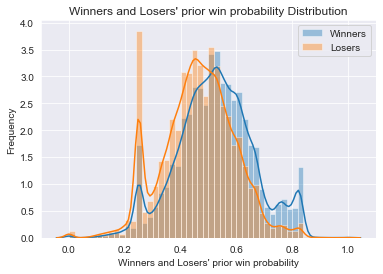

In [22]:
sns.distplot(df_atp['Winner_percentage'], label="Winners")
sns.distplot(df_atp['Loser_percentage'], label="Losers")
plt.ylabel('Frequency')
plt.xlabel('Winners and Losers\' prior win probability')
plt.title('Winners and Losers\' prior win probability Distribution')
plt.legend()

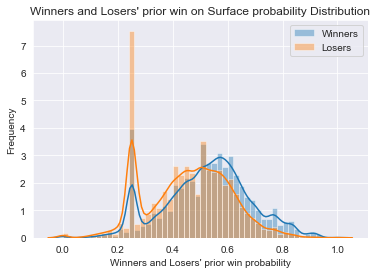

In [23]:
sns.distplot(df_atp['Winner_Surface'], label="Winners")
sns.distplot(df_atp['Loser_Surface'], label="Losers")
plt.ylabel('Frequency')
plt.xlabel('Winners and Losers\' prior win probability')
plt.title('Winners and Losers\' prior win on Surface probability Distribution')
plt.legend()

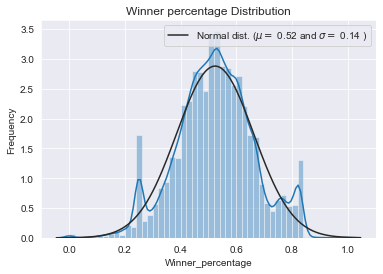

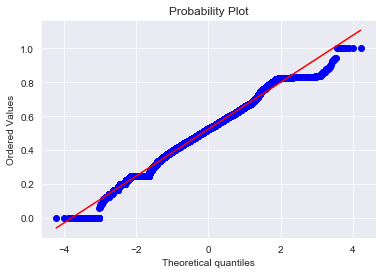

In [24]:
sns.distplot(df_atp['Winner_percentage'] , fit=norm);

(mu, sigma) = norm.fit(df_atp['Winner_percentage'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Winner percentage Distribution')
fig = plt.figure()
res = stats.probplot(df_atp['Winner_percentage'], plot=plt)

In [25]:
train_na = (df_atp.isnull().sum() / len(df_atp)) *100
train_na = train_na.drop(train_na[train_na ==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Percentage of Missing Values' : train_na})
missing_data

,Percentage of Missing Values
B&WL,98.047174
B&WW,98.047174
GBL,91.001335
GBW,91.001335
SBW,90.344459
SBL,90.344459
UBL,81.004005
UBW,81.004005
IWW,76.220739
IWL,76.220739


Text(0.5, 1.0, '% Missing Values by Feature')

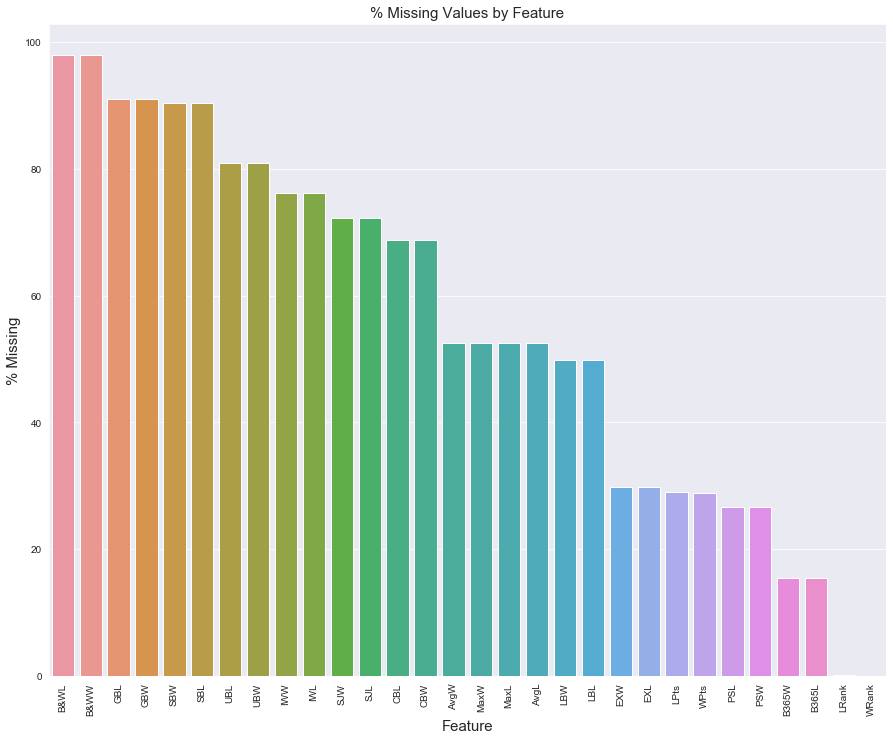

In [26]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('% Missing', fontsize=15)
plt.title('% Missing Values by Feature', fontsize=15)

### Seems like most of the missing values are betting odds so we'll get rid of these

In [27]:
for column in train_na.index[0:22]:
    df_atp.drop(column, axis=1, inplace=True)

Text(0.5, 1.0, '% Missing by Variable')

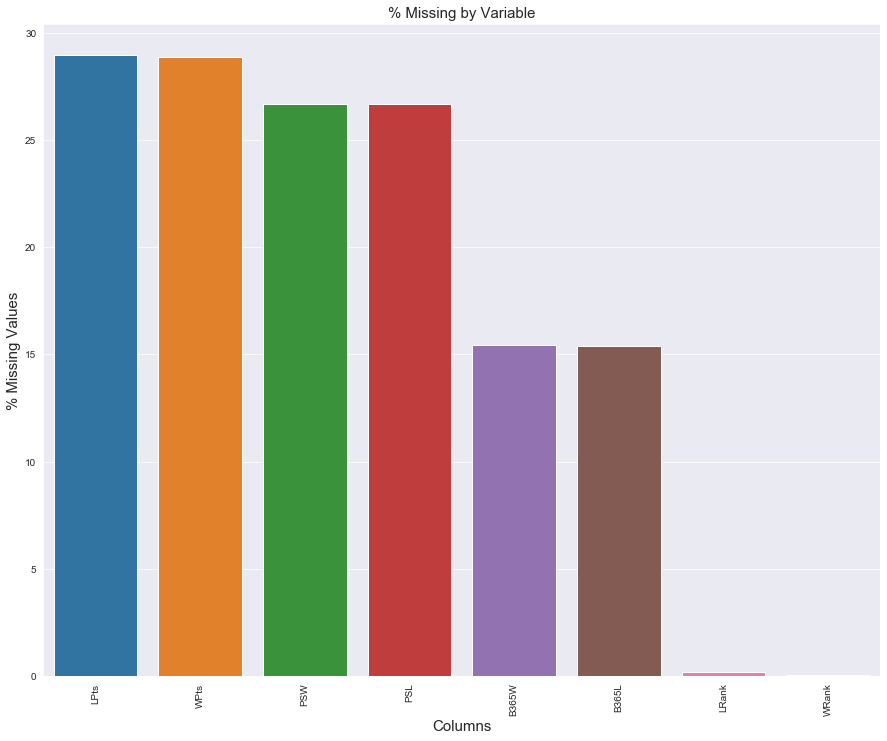

In [28]:
train_na = (df_atp.isnull().sum() / len(df_atp)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Percentage of missing values' :train_na})
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Columns', fontsize=15)
plt.ylabel('% Missing Values', fontsize=15)
plt.title('% Missing by Variable', fontsize=15)

In [29]:
for column in ['PSW','PSL']:
    df_atp.drop(column, axis=1, inplace=True)

### Don't want to lose too much data by getting rid of 'WPts' and 'LPts' missing data, so fill in with median of non-zero data. Get rid of the data that have a missing 'LRank' or 'WRank' value

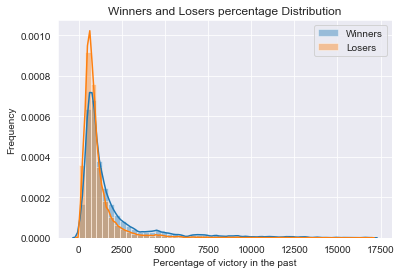

In [30]:
sns.distplot(df_atp['WPts'].dropna(), label="Winners")
sns.distplot(df_atp['LPts'].dropna(), label="Losers")
plt.ylabel('Frequency')
plt.xlabel('Percentage of victory in the past')
plt.title('Winners and Losers percentage Distribution')
plt.legend()

In [31]:
df_atp['WPts'].dropna().describe()

count    39967.000000
mean      1833.918007
std       2281.335056
min          1.000000
25%        648.000000
50%       1014.000000
75%       1895.000000
max      16950.000000
Name: WPts, dtype: float64

In [32]:
df_atp['LPts'].dropna().describe()

count    39894.000000
mean      1060.138166
std       1217.791366
min          1.000000
25%        504.000000
50%        749.000000
75%       1155.000000
max      16950.000000
Name: LPts, dtype: float64

In [33]:
for column in ['WPts','LPts']:
    df_atp[column] = df_atp[column].fillna(float(df_atp[column].dropna().median()))

In [34]:
df_atp = df_atp.dropna(axis=0, subset=['LRank','WRank'])

In [38]:
df_atp = df_atp[df_atp['LRank']!='NR']

In [39]:
df_atp = df_atp[df_atp['WRank']!='NR']

In [42]:
columns=['B365W','B365L']
for column in columns:
    df_atp[column]=df_atp[column].fillna(float(df_atp[column].mode()[0]))

In [43]:
df_atp['Comment'].unique()

array(['Completed', 'Retired', 'Walkover', 'Disqualified', 'Awarded',
       'Sched'], dtype=object)

In [44]:
df_atp.drop('Comment', axis=1, inplace=True)

In [45]:
df_atp = df_atp.sort_values(by = 'Date')
df_atp.reset_index(drop=True, inplace=True)

### Calculate Elo ranking (used in Chess)

In [46]:
# Elo rating calculation
def compute_elo_rankings(data):
    """
    Given the list of matches in chronological order, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    """
    print("Elo rankings computing...")
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index)
    elo=pd.Series(np.ones(len(players))*1500,index=players)
    ranking_elo=[(1500,1500)]
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner
        l=data.iloc[i-1,:].Loser
        elow=elo[w]
        elol=elo[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))    
        K_factor=32
        new_elow=elow+K_factor*(1-pwin)
        new_elol=elol-K_factor*(1-pwin)
        elo[w]=new_elow
        elo[l]=new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%5000==0:
            print(str(i)+" matches computed...")
    ranking_elo=pd.DataFrame(ranking_elo,columns=["elo_winner","elo_loser"])    
    ranking_elo["proba_elo"]=1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    return ranking_elo

In [47]:
Elo = compute_elo_rankings(df_atp)

Elo rankings computing...
5000 matches computed...
10000 matches computed...
15000 matches computed...
20000 matches computed...
25000 matches computed...
30000 matches computed...
35000 matches computed...
40000 matches computed...
45000 matches computed...
50000 matches computed...
55000 matches computed...


In [48]:
df_atp["Elo_Winner"] = Elo["elo_winner"]
df_atp["Elo_Loser"] = Elo["elo_loser"]
df_atp["Proba_Elo"]= Elo["proba_elo"]

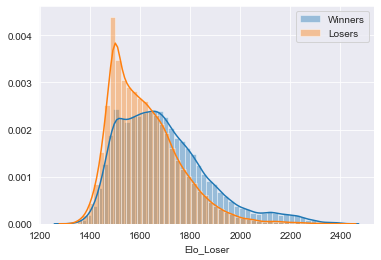

In [49]:
sns.distplot(df_atp["Elo_Winner"], label="Winners")
sns.distplot(df_atp["Elo_Loser"], label="Losers")
plt.legend()

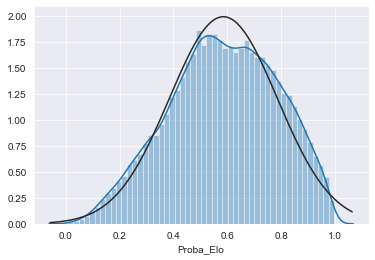

In [50]:
sns.distplot(df_atp["Proba_Elo"],fit=norm)

### We don't need the # of sets and games won per match now that we've already calculated running win %'s since this information is only known after the match is played

In [51]:
df_atp.drop(['Wsets','Lsets','L1', 'L2', 'L3', 'L4','L5',
             'W1', 'W2', 'W3', 'W4', 'W5'], axis = 1, inplace = True)

In [ ]:
# import PyPDF2

In [ ]:
# # creating a pdf file object 
# pdfFileObj = open('desktop/coding/sports_betting/tennis/birthdays.pdf', 'rb') 
  
# # creating a pdf reader object 
# pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
  
# # printing number of pages in pdf file 
# print(pdfReader.numPages) 
  
# # creating a page object 
# pageObj = pdfReader.getPage(1) 
  
# # extracting text from page 
# birthdays1 = pageObj.extractText()
  
# # closing the pdf file object 
# pdfFileObj.close() 

In [ ]:
# import urllib
# import requests
# from bs4 import BeautifulSoup

In [ ]:
# Function to find players' birthdates. Only works if Wikipedia is the first google result

def player_birthday(name):
    query = name + '+birthday+tennis+wikipedia'
    URL = 'https://google.com/search?q=' + query + '&num=10'
    USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:65.0) Gecko/20100101 Firefox/65.0'
    headers = {'user-agent' : USER_AGENT}
    resp = requests.get(URL, headers=headers)
    soup = BeautifulSoup(resp.content, 'html5lib')
    result_divs = soup.findAll('div',{'class':'r'})
    links = [div.find('a') for div in result_divs]
    hrefs = [link.get('href') for link in links]
    for refs in hrefs:
        if 'wikipedia' in refs:
            new_url = refs
            break
    
    page = requests.get(new_url, headers=headers)
    soup = BeautifulSoup(page.content, 'html5lib')
    badge = soup.findAll('span', {'class':'bday'})
    bday = badge[0].text
    return bday

In [52]:
df_atp.columns

Index(['B365L', 'B365W', 'Best of', 'Court', 'Date', 'LPts', 'LRank',
       'Location', 'Loser', 'Round', 'Series', 'Surface', 'Tournament', 'WPts',
       'WRank', 'Winner', 'Winner_percentage', 'Loser_percentage',
       'Winner_Surface', 'Loser_Surface', 'Winner_perc_sets',
       'Loser_perc_sets', 'Winner_perc_sets_surface',
       'Loser_perc_sets_surface', 'Winner_perc_games', 'Loser_perc_games',
       'Winner_perc_games_surface', 'Loser_perc_games_surface', 'Elo_Winner',
       'Elo_Loser', 'Proba_Elo'],
      dtype='object')

In [53]:
df_atp_losers = df_atp.copy()

### We have made a copy of the dataset and are flipping the winner and loser data. We will then combine this with the original data set. This is so we will have both positivie and negative target values for training, instead of just positive target values.

In [54]:
df_atp_losers['Winner_perc_games_surface'] = df_atp['Loser_perc_games_surface']
df_atp_losers['Loser_perc_games_surface'] = df_atp['Winner_perc_games_surface']
df_atp_losers['Winner_perc_games'] = df_atp['Loser_perc_games']
df_atp_losers['Loser_perc_games'] = df_atp['Winner_perc_games']
df_atp_losers['Winner_perc_sets_surface'] = df_atp['Loser_perc_sets_surface']
df_atp_losers['Loser_perc_sets_surface'] = df_atp['Winner_perc_sets_surface']
df_atp_losers['Winner_perc_sets'] = df_atp['Loser_perc_sets']
df_atp_losers['Loser_perc_sets'] = df_atp['Winner_perc_sets']
df_atp_losers['Winner_Surface'] = df_atp['Loser_Surface']
df_atp_losers['Loser_Surface'] = df_atp['Winner_Surface']
df_atp_losers['Winner_percentage'] = df_atp['Loser_percentage']
df_atp_losers['Loser_percentage'] = df_atp['Winner_percentage']

df_atp_losers['Elo_Winner'] = df_atp['Elo_Loser']
df_atp_losers['Elo_Loser'] = df_atp['Elo_Winner']
df_atp_losers['Proba_Elo'] = 1 - df_atp['Proba_Elo']

df_atp_losers['LPts'] = df_atp['WPts']
df_atp_losers['LRank'] = df_atp['WRank']
df_atp_losers['WPts'] = df_atp['LPts']
df_atp_losers['WRank'] = df_atp['LRank']

df_atp_losers['Winner'] = df_atp['Loser']
df_atp_losers['Loser'] = df_atp['Winner']

df_atp_losers['B365W'] = df_atp['B365L']
df_atp_losers['B365L'] = df_atp['B365W']

In [ ]:
# # Elo data
# elo_rankings = df_atp[["Elo_Winner","Elo_Loser","Proba_Elo"]]
# elo_1 = elo_rankings
# elo_2 = elo_1[["Elo_Loser","Elo_Winner","Proba_Elo"]]
# elo_2.columns = ["Elo_Winner","Elo_Loser","Proba_Elo"]
# elo_2.Proba_Elo = 1-elo_2.Proba_Elo

# # Player prior win probability
# win_percentage = df_atp[['Winner_percentage', 'Loser_percentage']]
# win_1 = win_percentage
# win_2 = win_1[['Loser_percentage','Winner_percentage']]
# win_2.columns = ['Winner_percentage', 'Loser_percentage']

# # Player prior win surface probability
# win_percentage_surface = df_atp[['Winner_Surface', 'Loser_Surface']]
# win_1_surface = win_percentage_surface
# win_2_surface = win_1_surface[['Loser_Surface','Winner_Surface']]
# win_2_surface.columns = ['Winner_Surface', 'Loser_Surface']

# # Player entry points
# Pts = df_atp[['WPts','LPts']]
# Pts_1 = Pts
# Pts_2 = Pts_1[['LPts','WPts']]
# Pts_2.columns = ['WPts','LPts']

# # Player Entry Ranking
# Rank = df_atp[['WRank','LRank']]
# Rank_1 = Rank
# Rank_2 = Rank_1[['LRank','WRank']]
# Rank_2.columns = ['WRank','LRank']

# #Player Odds for winning
# Odds = df_atp[['B365W','B365L']]
# Odds_1 = Odds
# Odds_2 = Odds_1[['B365L','B365W']]
# Odds_2.columns = ['B365W','B365L']

In [ ]:
# df_atp_losers.drop(["Elo_Winner","Elo_Loser","Proba_Elo"],axis=1,inplace=True)
# df_atp_losers.drop(['Winner_percentage', 'Loser_percentage','WPts','LPts','WRank','LRank',
#                     'B365W','B365L','Winner_Surface','Loser_Surface'], axis=1, inplace=True)
# df_atp_losers.head()

In [ ]:
# df_atp_losers[["Elo_Winner","Elo_Loser","Proba_Elo"]] = elo_2
# df_atp_losers[['Winner_percentage', 'Loser_percentage']] = win_2
# df_atp_losers[['Winner_Surface', 'Loser_Surface']] = win_2_surface
# df_atp_losers[['WPts','LPts']] = Pts_2
# df_atp_losers[['WRank','LRank']] = Rank_2
# df_atp_losers[['B365W','B365L']] = Odds_2
# df_atp_losers.head()

In [55]:
df_atp_losers['Target'] = 0
df_atp['Target'] = 1

### Add in birthdates for age calculation

In [56]:
b_days = pd.read_excel(r'desktop/birthdates.xlsx')

In [57]:
b_days.to_csv('atp_bdays.csv')

In [58]:
b_days = pd.read_csv('atp_bdays.csv', index_col=0)
b_days.head()

,Name,DOB
0,Dosedel S.,1970-08-14
1,Enqvist T.,1974-03-13
2,Escude N.,1976-04-03
3,Federer R.,1981-08-08
4,Fromberg R.,1970-04-28


In [59]:
bday_dict = b_days.set_index('Name').T.to_dict('list')

In [60]:
df_atp['winner_bday'] = df_atp['Winner'].map(bday_dict)
df_atp_losers['winner_bday'] = df_atp_losers['Winner'].map(bday_dict)
df_atp['loser_bday'] = df_atp['Loser'].map(bday_dict)
df_atp_losers['loser_bday'] = df_atp_losers['Loser'].map(bday_dict)

In [61]:
df_atp.head()

,B365L,B365W,Best of,Court,Date,LPts,LRank,Location,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,Winner_percentage,Loser_percentage,Winner_Surface,Loser_Surface,Winner_perc_sets,Loser_perc_sets,Winner_perc_sets_surface,Loser_perc_sets_surface,Winner_perc_games,Loser_perc_games,Winner_perc_games_surface,Loser_perc_games_surface,Elo_Winner,Elo_Loser,Proba_Elo,Target,winner_bday,loser_bday
0,2.75,1.4,3,Outdoor,2000-01-03,749.0,77,Adelaide,Ljubicic I.,1st Round,International,Hard,Australian Hardcourt Championships,1014.0,63,Dosedel S.,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.250000,0.25,0.250000,0.25,1500.0,1500.0,0.5,1,[1970-08-14],[1979-03-19]
1,2.75,1.4,3,Outdoor,2000-01-03,749.0,21,Adelaide,Spadea V.,1st Round,International,Hard,Australian Hardcourt Championships,1014.0,55,Martin A.,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.538462,0.25,0.538462,0.25,1500.0,1500.0,0.5,1,[1970-07-08],[1974-07-19]
2,2.75,1.4,3,Outdoor,2000-01-03,749.0,56,Adelaide,Clement A.,1st Round,International,Hard,Australian Hardcourt Championships,1014.0,5,Enqvist T.,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.565217,0.25,0.565217,0.25,1500.0,1500.0,0.5,1,[1974-03-13],[1977-12-17]
3,2.75,1.4,3,Outdoor,2000-01-03,749.0,655,Adelaide,Baccanello P.,1st Round,International,Hard,Australian Hardcourt Championships,1014.0,40,Escude N.,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.565217,0.25,0.565217,0.25,1500.0,1500.0,0.5,1,[1976-04-03],[nan]
4,2.75,1.4,3,Outdoor,2000-01-03,749.0,87,Adelaide,Knippschild J.,1st Round,International,Hard,Australian Hardcourt Championships,1014.0,65,Federer R.,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.434783,0.25,0.434783,0.25,1500.0,1500.0,0.5,1,[1981-08-08],[1959-02-16]


In [62]:
df_atp['winner_bday'] =df_atp.winner_bday.apply(lambda x: str(x[0]))
df_atp_losers['winner_bday'] =df_atp_losers.winner_bday.apply(lambda x: str(x[0]))
df_atp['loser_bday'] =df_atp.loser_bday.apply(lambda x: str(x[0]))
df_atp_losers['loser_bday'] =df_atp_losers.loser_bday.apply(lambda x: str(x[0]))

In [63]:
df_atp = df_atp[df_atp['winner_bday'] != 'nan']
df_atp = df_atp[df_atp['loser_bday'] != 'nan']
df_atp_losers = df_atp_losers[df_atp_losers['winner_bday'] != 'nan']
df_atp_losers = df_atp_losers[df_atp_losers['loser_bday'] != 'nan']

In [64]:
df_atp['winner_bday'] =df_atp.winner_bday.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
df_atp['loser_bday'] =df_atp.loser_bday.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
df_atp_losers['winner_bday'] =df_atp_losers.winner_bday.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
df_atp_losers['loser_bday'] =df_atp_losers.loser_bday.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [65]:
df_atp['age_winner'] = (df_atp['Date'] - df_atp['winner_bday']).dt.days / 365.25
df_atp['age_loser'] = (df_atp['Date'] - df_atp['loser_bday']).dt.days / 365.25
df_atp_losers['age_winner'] = (df_atp_losers['Date'] - df_atp_losers['winner_bday']).dt.days / 365.25
df_atp_losers['age_loser'] = (df_atp_losers['Date'] - df_atp_losers['loser_bday']).dt.days / 365.25

In [66]:
df = df_atp.append(df_atp_losers)

In [67]:
df = df.sort_values(by='Date')
df.reset_index(drop=True, inplace=True)

In [68]:
df['Round'].unique()

array(['1st Round', 'Quarterfinals', 'Semifinals', '2nd Round',
       'The Final', '4th Round', '3rd Round', 'Round Robin'], dtype=object)

In [ ]:
# def round_encoder(x):
#     if x == '1st Round':
#         return 1
#     elif x== '2nd Round':
#         return 2
#     elif x== '3rd Round':
#         return 3
#     elif x== '4th Round':
#         return 4
#     elif x== 'Quarterfinals':
#         return 5
#     elif x== 'Semifinals':
#         return 6
#     elif x== 'The Final':
#         return 7
#     else:
#         return 0

In [ ]:
# df_new['Round'] = df_new['Round'].apply(lambda x: round_encoder(x))

In [69]:
df.drop(['Best of','Winner','Loser','Location',
         'Tournament','winner_bday', 'loser_bday'], axis=1, inplace=True)

In [ ]:
# one_hot = pd.get_dummies(data = df, columns = ['Court','Round','Series','Surface'])

# df[one_hot.columns] = one_hot

# df.drop(['Court','Round','Series','Surface'],axis=1,inplace=True)
# df.head()

In [70]:
df.columns

Index(['B365L', 'B365W', 'Court', 'Date', 'LPts', 'LRank', 'Round', 'Series',
       'Surface', 'WPts', 'WRank', 'Winner_percentage', 'Loser_percentage',
       'Winner_Surface', 'Loser_Surface', 'Winner_perc_sets',
       'Loser_perc_sets', 'Winner_perc_sets_surface',
       'Loser_perc_sets_surface', 'Winner_perc_games', 'Loser_perc_games',
       'Winner_perc_games_surface', 'Loser_perc_games_surface', 'Elo_Winner',
       'Elo_Loser', 'Proba_Elo', 'Target', 'age_winner', 'age_loser'],
      dtype='object')

In [71]:
df.shape

(110986, 29)

In [72]:
df.to_excel('desktop/tennis_data.xlsx')

In [73]:
df.to_csv('Notebooks_other/tennis_data.csv')

# Model Building

In [6]:
df_atp = pd.read_csv('tennis_data.csv', index_col=0)

In [7]:
df_atp.head()

,B365L,B365W,Court,Date,LPts,LRank,Round,Series,Surface,WPts,WRank,Winner_percentage,Loser_percentage,Winner_Surface,Loser_Surface,Winner_perc_sets,Loser_perc_sets,Winner_perc_sets_surface,Loser_perc_sets_surface,Winner_perc_games,Loser_perc_games,Winner_perc_games_surface,Loser_perc_games_surface,Elo_Winner,Elo_Loser,Proba_Elo,Target,age_winner,age_loser
0,2.75,1.40,Outdoor,2000-01-03,749.0,77.0,1st Round,International,Hard,1014.0,63.0,0.25,0.25,0.25,0.25,0.25,0.250000,0.25,0.250000,0.250000,0.250000,0.250000,0.250000,1500.000000,1500.000000,0.500000,1,29.388090,20.793977
1,1.40,2.75,Outdoor,2000-01-03,1014.0,162.0,1st Round,International,Hard,749.0,67.0,0.25,0.25,0.25,0.25,0.25,0.400000,0.25,0.400000,0.250000,0.500000,0.250000,0.500000,1500.000000,1500.000000,0.500000,0,30.242300,22.787132
2,1.40,2.75,Outdoor,2000-01-03,1014.0,24.0,Quarterfinals,International,Hard,749.0,84.0,0.25,0.25,0.25,0.25,0.80,0.727273,0.80,0.727273,0.600000,0.622222,0.600000,0.622222,1532.000000,1516.000000,0.523010,0,29.749487,18.855578
3,1.40,2.75,Outdoor,2000-01-03,1014.0,15.0,Quarterfinals,International,Hard,749.0,55.0,0.25,0.25,0.25,0.25,0.25,0.714286,0.25,0.714286,0.619048,0.522388,0.619048,0.522388,1531.263693,1532.000000,0.498940,0,29.489391,23.594798
4,1.40,2.75,Outdoor,2000-01-03,1014.0,5.0,Semifinals,International,Hard,749.0,15.0,0.25,0.25,0.25,0.25,0.25,0.777778,0.25,0.777778,0.595238,0.543478,0.595238,0.543478,1547.966092,1547.297533,0.500962,0,23.594798,25.809719


In [8]:
df_atp["Date"] =df_atp.Date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [9]:
def rank_clean(x):
    if type(x) == int:
        return x
    elif type(x) == float:
        return int(x)
    elif type(x) == str:
        return int(float(x))

In [10]:
df_atp['LRank'] = df_atp['LRank'].apply(lambda x: rank_clean(x))
df_atp['WRank'] = df_atp['WRank'].apply(lambda x: rank_clean(x))

In [11]:
#Test set will be the matches in November
end_train = datetime(2020,11,1)
beg_test = datetime(2020,11,1)
end_test = datetime(2020,11,30)
train = df_atp[df_atp['Date']<end_train]
test = df_atp[(df_atp['Date']>=beg_test)&(df_atp['Date']<end_test)]

In [12]:
X = train.drop(columns=['B365L', 'B365W','Date','Target'])
y = train['Target']
X_test_set = test.drop(columns=['B365L', 'B365W','Date','Target'])
y_test_set = test['Target']

In [13]:
X.columns

Index(['Court', 'LPts', 'LRank', 'Round', 'Series', 'Surface', 'WPts', 'WRank',
       'Winner_percentage', 'Loser_percentage', 'Winner_Surface',
       'Loser_Surface', 'Winner_perc_sets', 'Loser_perc_sets',
       'Winner_perc_sets_surface', 'Loser_perc_sets_surface',
       'Winner_perc_games', 'Loser_perc_games', 'Winner_perc_games_surface',
       'Loser_perc_games_surface', 'Elo_Winner', 'Elo_Loser', 'Proba_Elo',
       'age_winner', 'age_loser'],
      dtype='object')

### Preprocessing data with Scikit Learn column transformer

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(
[('scaling', StandardScaler(),['LPts', 'LRank','WPts', 'WRank','Winner_percentage', 
                               'Loser_percentage', 'Winner_Surface','Loser_Surface', 
                               'Winner_perc_sets', 'Loser_perc_sets','Winner_perc_sets_surface', 
                               'Loser_perc_sets_surface','Winner_perc_games', 'Loser_perc_games', 
                               'Winner_perc_games_surface','Loser_perc_games_surface', 'Elo_Winner', 
                               'Elo_Loser', 'Proba_Elo','age_winner', 'age_loser']),
('one hot', OneHotEncoder(sparse=False),['Round','Court','Series','Surface'])])

ct.fit(X)
X_train_trans = ct.transform(X) #Only train on the training data. Don't retrain on test data
X_test_trans = ct.transform(X_test_set)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_trans,y,stratify=y,random_state=42)

# Model-based Feature Selection

In [16]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [17]:
select = SelectFromModel(RandomForestClassifier(n_estimators = 100,
                                               random_state=42), threshold='median')

In [18]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print('X_train.shape: {}'.format(X_train.shape))
print('X_train_l1.shape: {}'.format(X_train_l1.shape))

X_train.shape: (83091, 43)
X_train_l1.shape: (83091, 22)


([], <a list of 0 Text yticklabel objects>)

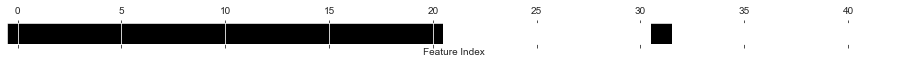

In [19]:
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Feature Index')
plt.yticks(())

In [20]:
X_test_l1 = select.transform(X_test)

In [21]:
X_train_final = select.transform(X_train_trans)
X_train_final.shape

(110788, 22)

In [22]:
X_test_final = select.transform(X_test_trans)
X_test_final.shape

(198, 22)

# Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
select = RFE(RandomForestClassifier(n_estimators=100,random_state=42),
            n_features_to_select=int(X_train.shape[1]/2))

In [ ]:
select.fit(X_train,y_train)

In [ ]:
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Feature Index')
plt.yticks(())

In [ ]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

## Hyperparameter Tuning

In [110]:
param_grid = {'max_depth' : [1,2,3,4,5],
              'learning_rate' : [0.001,0.01,0.1,1]}

In [111]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(gbrt, param_grid, cv=5, return_train_score=True)

In [114]:
grid_search.fit(X_train_l1,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [115]:
print('Accuracy on training set: {:.3f}'.format(grid_search.score(X_train_l1,y_train)))
print('Accuracy on test set: {:.3f}'.format(grid_search.score(X_test_l1,y_test)))

Accuracy on training set: 0.781
Accuracy on test set: 0.773


In [116]:
print('Best Parameters: {}'.format(grid_search.best_params_))
print('Best CV Score: {:.3f}'.format(grid_search.best_score_))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4}
Best CV Score: 0.773


In [99]:
from sklearn.metrics import roc_curve

In [100]:
fpr_gbrt, tpr_gbrt, thresholds_gbrt = roc_curve(y_test, gbrt.predict_proba(X_test)[:,1])

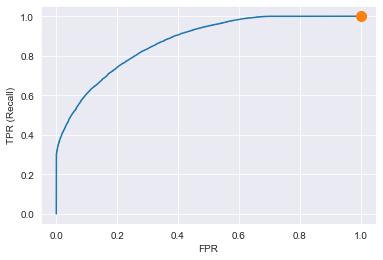

In [101]:
close_zero = np.argmin(np.abs(thresholds_gbrt))

plt.plot(fpr_gbrt, tpr_gbrt, label='ROC Curve GBRT')
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.plot(fpr_gbrt[close_zero],tpr_gbrt[close_zero],'o',markersize=10)

In [102]:
from sklearn.metrics import roc_auc_score

In [103]:
gbrt_auc = roc_auc_score(y_test, gbrt.predict_proba(X_test)[:,1])
print('AUC for GBRT: {:.3f}'.format(gbrt_auc))

AUC for GBRT: 0.872


In [104]:
from sklearn.metrics import confusion_matrix

In [105]:
cf = confusion_matrix(y_test,gbrt.predict(X_test))

(0, 2)

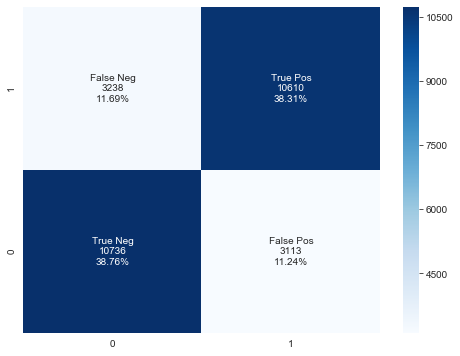

In [106]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
ax.set_ylim([0,2])

# Support Vector Classifier (SVC)

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Only use for 'smaller' datasets of around 10,000 datapoints; computationally expensive
svc = SVC(C=1000)
svc.fit(X_train,y_train)

In [ ]:
print('Accuracy on training set: {:.3f}'.format(svc.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(svc.score(X_test,y_test)))

# Multilayered Perceptron (plain vanilla neural network)

In [107]:
from sklearn.neural_network import MLPClassifier

In [126]:
mlp = MLPClassifier(random_state=0,max_iter = 1000,hidden_layer_sizes=[50,50,50])

In [127]:
mlp.fit(X_train_l1, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[50, 50, 50], learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [128]:
print('Accuracy on training set: {:.3f}'.format(mlp.score(X_train_l1,y_train)))
print('Accuracy on test set: {:.3f}'.format(mlp.score(X_test_l1,y_test)))

Accuracy on training set: 0.821
Accuracy on test set: 0.751


In [ ]:
param_grid = {'max_depth' : [1,2,3,4,5],
              'learning_rate' : [0.001,0.01,0.1,1]}

In [ ]:
grid_search = GridSearchCV(mlp, param_grid, cv=5, return_train_score=True)

In [ ]:
grid_search.fit(X_train_l1,y_train)

# Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
forest = RandomForestClassifier(n_estimators = 100, random_state=5, max_features=5)
forest.fit(X_train_l1, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [91]:
print('Accuracy on training set: {:.3f}'.format(forest.score(X_train_l1,y_train)))
print('Accuracy on test set: {:.3f}'.format(forest.score(X_test_l1,y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.766


### Shuffle-Split Cross-Validation

In [92]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [93]:
shuffle_split = ShuffleSplit(test_size=0.4,train_size=0.6,n_splits=10)

In [94]:
scores = cross_val_score(forest,X_train,y_train, cv=shuffle_split)

In [95]:
print('Cross Validation Scores: \n{}'.format(scores))
print('Mean Cross Validation Score: {}'.format(scores.mean()))

Cross Validation Scores: 
[0.76607395 0.7668863  0.76646508 0.76628456 0.76372717 0.76848091
 0.7655023  0.76375726 0.76637482 0.7675783 ]
Mean Cross Validation Score: 0.766113066762945


# Gradient Bosting Regression Trees

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
gbrt = GradientBoostingClassifier(learning_rate=0.1, max_depth=4,random_state=0)
gbrt.fit(X_train_l1, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [25]:
print('Accuracy on training set: {:.3f}'.format(gbrt.score(X_train_l1,y_train)))
print('Accuracy on test set: {:.3f}'.format(gbrt.score(X_test_l1,y_test)))

Accuracy on training set: 0.781
Accuracy on test set: 0.773


In [26]:
gbrt.fit(X_train_final,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [27]:
print('Accuracy on FINAL training set: {:.3f}'.format(gbrt.score(X_train_final,y)))

Accuracy on FINAL training set: 0.779


In [28]:
predictions = gbrt.predict(X_test_final)

In [29]:
probabilities = gbrt.predict_proba(X_test_final)

In [30]:
merged = pd.DataFrame(np.column_stack((predictions,probabilities,y_test_set)))

In [31]:
merged.columns = ['Prediction','Probability of Loss','Probability of Win','Actual Result']

In [32]:
merged.head()

,Prediction,Probability of Loss,Probability of Win,Actual Result
0,0.0,0.556951,0.443049,0.0
1,0.0,0.822079,0.177921,0.0
2,1.0,0.186743,0.813257,1.0
3,1.0,0.448511,0.551489,1.0
4,0.0,0.645557,0.354443,1.0


In [33]:
merged['Correct'] = merged['Actual Result'].eq(merged['Prediction'])

In [34]:
merged.head()

,Prediction,Probability of Loss,Probability of Win,Actual Result,Correct
0,0.0,0.556951,0.443049,0.0,True
1,0.0,0.822079,0.177921,0.0,True
2,1.0,0.186743,0.813257,1.0,True
3,1.0,0.448511,0.551489,1.0,True
4,0.0,0.645557,0.354443,1.0,False


In [35]:
merged['Correct'].sum()/len(merged['Correct'])

0.696969696969697

In [36]:
new_merged = pd.concat([test.reset_index(),merged.reset_index()],axis=1, sort=False)
new_merged.head()

,index,B365L,B365W,Court,Date,LPts,LRank,Round,Series,Surface,WPts,WRank,Winner_percentage,Loser_percentage,Winner_Surface,Loser_Surface,Winner_perc_sets,Loser_perc_sets,Winner_perc_sets_surface,Loser_perc_sets_surface,Winner_perc_games,Loser_perc_games,Winner_perc_games_surface,Loser_perc_games_surface,Elo_Winner,Elo_Loser,Proba_Elo,Target,age_winner,age_loser,index,Prediction,Probability of Loss,Probability of Win,Actual Result,Correct
0,110788,2.20,1.61,Indoor,2020-11-01,1166.0,45,The Final,ATP250,Hard,1296.0,39,0.458140,0.443182,0.457447,0.463415,0.462878,0.465409,0.473011,0.483582,0.489095,0.496495,0.494022,0.504374,1649.937409,1678.183122,0.459440,0,32.342231,31.383984,0,0.0,0.556951,0.443049,0.0,True
1,110789,1.14,5.50,Indoor,2020-11-01,3429.0,8,The Final,ATP500,Hard,1253.0,42,0.461538,0.595855,0.384615,0.597222,0.462312,0.555328,0.402985,0.554286,0.487205,0.520149,0.472429,0.521499,1669.042485,1996.130689,0.132059,0,25.478439,23.033539,1,0.0,0.822079,0.177921,0.0,True
2,110790,5.50,1.14,Indoor,2020-11-01,1253.0,42,The Final,ATP500,Hard,3429.0,8,0.595855,0.461538,0.597222,0.384615,0.555328,0.462312,0.554286,0.402985,0.520149,0.487205,0.521499,0.472429,1996.130689,1669.042485,0.867941,1,23.033539,25.478439,2,1.0,0.186743,0.813257,1.0,True
3,110791,1.61,2.20,Indoor,2020-11-01,1296.0,39,The Final,ATP250,Hard,1166.0,45,0.443182,0.458140,0.463415,0.457447,0.465409,0.462878,0.483582,0.473011,0.496495,0.489095,0.504374,0.494022,1678.183122,1649.937409,0.540560,1,31.383984,32.342231,3,1.0,0.448511,0.551489,1.0,True
4,110792,1.25,3.75,Indoor,2020-11-02,1518.0,33,1st Round,Masters 1000,Hard,772.0,90,0.398693,0.476190,0.393617,0.500000,0.426108,0.477273,0.425620,0.490066,0.475635,0.495928,0.470437,0.499336,1607.327930,1649.209736,0.440017,1,30.976044,23.723477,4,0.0,0.645557,0.354443,1.0,False


In [39]:
# Kelly Criterion
# calculates fraction of current bankroll to wager

def kelly_criterion(p,b):
    # b:net fractional odds received on wager
    # p:probability of win
    return (p * (b+1) -1) / b

In [70]:
kelly_criterion(p=new_merged['Probability of Loss'][1],b=(new_merged['B365L'][1]-1))

-0.4487864872257967

In [68]:
def bet_kelly(bank,df):
    amt = 0
    temp_bank = bank
    for i,_ in df.iterrows():
        if df['Correct'][i]:
            if df['Prediction'][i]:
                amt = bank * kelly_criterion(p=df['Probability of Win'][i],b=(df['B365W'][i]-1))
                temp_bank = temp_bank + amt * (df['B365W'][i] - 1)
            else:
                amt = bank * kelly_criterion(p=df['Probability of Loss'][i],b=(df['B365L'][i]-1))
                temp_bank = temp_bank + amt * (df['B365L'][i] - 1)
        else:
            if df['Prediction'][i]:
                amt = bank * kelly_criterion(p=df['Probability of Win'][i],b=(df['B365W'][i]-1))
                temp_bank = temp_bank - amt
            else:
                amt = bank * kelly_criterion(p=df['Probability of Loss'][i],b=(df['B365L'][i]-1))
                temp_bank = temp_bank - amt
        if i < len(df)-1:
            if df['Date'][i+1] != df['Date'][i]:
                bank = temp_bank
        print('Bank: {:.2f}, Bet Size: {:.2f}'.format(temp_bank,amt))
    return 0

In [54]:
def bet(bank,df):
    amt = bank / 40
    for i,_ in df.iterrows():
        if df['Correct'][i]:
            if df['Prediction'][i]:
                bank = bank + amt*(df['B365W'][i] - 1)
            else:
                bank = bank + amt*(df['B365L'][i] - 1)
        else:
            bank = bank - amt
        if i < len(df)-1:
            if df['Date'][i+1] != df['Date'][i]:
                amt = bank / 40
        print('Bank: {:.2f}, Bet Size: {:.2f}'.format(bank,amt))
    return bank, amt

In [105]:
bet = 10
bank = 0
for i,_ in new_merged.iterrows():
    if new_merged['Correct'][i]:
        bank = bank + bet*new_merged['B365W'][i]
    else:
        bank = bank - bet

In [106]:
total_risked = bet*len(new_merged)
roi = (bank-total_risked)/total_risked
profit = bank-total_risked
print('Total Risked: {:.2f}'.format(total_risked))
print('Profit: {:.2f}'.format(profit))
print('ROI: {:.2f}%'.format(roi*100))

Total Risked: 1980.00
Profit: 844.60
ROI: 42.66%
